## Loading packages, constants, and functions

In [1]:
import functions as f
import constants as c
import classes as cl

import pandas as pd
import os, joblib, time

import netwulf as wulf
import json

import warnings

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import random

print(f"Current directories in {c.cwd}\n {os.listdir()}")

long = c.cwd + "\\raw_data\\long_alzheimers.tsv"
short = c.cwd + "\\raw_data\\short_alzheimers.tsv"

Current directories in /Users/s243564/Computational Tools/02807_project_Group13-1\
 ['joblib_vars', 'functions.py', 'modularity.ipynb', 'test_data', 'Notebook.ipynb', 'constants.py', 'runclass.ipynb', 'raw_data', '__pycache__', 'CustomPool_logs', 'README.md', '.gitignore', 'OldCode_saveforReport.ipynb', 'comp_tls', 'enrichment.ipynb', 'classes.py', '.git', 'miserables.json']


## Loading Datasets

#### Creating id_prot and saving
id_prot is a dictionary meant to point a id <integer> to a protein name <string> with 19 str characters \
id_prot is saved using joblib.dump() in dir "joblib_vars", and can be reloaded as a dict object using joblib.load(path)

In [ ]:
chunksize = 10
info_df = pd.read_csv("https://stringdb-downloads.org/download/protein.info.v12.0/9606.protein.info.v12.0.txt.gz", compression='gzip', sep="\t")
info_df = info_df[["#string_protein_id"]].values
id_prot = dict()
for c, e in enumerate(info_df):
    id_prot[c] = e[0]
print(id_prot)
joblib.dump(id_prot, "./joblib_vars/id_prot.joblib")

#### Modifying raw datasets
modified datasets are stored in "/mod_data/" for easy retrieval

In [ ]:
"""
An example of an interaction dataset loaded
"""
alz_int_df = pd.read_csv("./raw_data/long_alzheimers.tsv", sep="\t")
alz_int_df.columns = ["Prot1_ShortName", "Prot2_ShortName", "protein1", "protein2", "col1", "col2", "col3", "col4", "col5", "col6", "col7", "col8", "col9"]
alz_int_df

In [ ]:
HS_int_df = pd.read_csv("https://stringdb-downloads.org/download/protein.links.detailed.v12.0/9606.protein.links.detailed.v12.0.txt.gz", compression="gzip", sep=" ")
HS_int_df = HS_int_df[HS_int_df["experimental"] > 0] #removing interactions with no experimental relevance 
#joblib.dump(HS_int_df, "./joblib_vars/HS_int_df") #FILE TOO LARGE 
HS_int_df


Creating HS_int_simple, containing protein1 and protein2 names converted to int using id_prot. \
If all interactions are weight=1, only the names (ids) of the proteins are needed when constructing the interaction network

In [1]:
id_prot = joblib.load("./joblib_vars/id_prot.joblib")

#Swapping key value in dict
id_swap = dict()
for k, v in id_prot.items():
    id_swap[str(v)] = k
print(id_swap)

#exporting modified HS_int
HS_int_simple = HS_int_df.map(lambda x: id_swap[x] if x in id_swap else x).reset_index()
HS_int_simple = HS_int_simple[["protein1", "protein2"]]
joblib.dump(HS_int_simple, "./joblib_vars/HS_int_simple.joblib")


NameError: name 'joblib' is not defined

## Running the class

### Setting the color of the progress bar

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

### Running the class

In [3]:
warnings.filterwarnings("ignore", category=UserWarning, message=r".*urllib3.*NotOpenSSLWarning.*")

a = cl.interaction_network(testdataset = False, threshold=0.95)
a.create_encoding_dict(file_url="https://stringdb-downloads.org/download/protein.info.v12.0/9940.protein.info.v12.0.txt.gz")
a.load_data(file_url="https://stringdb-downloads.org/download/stream/protein.links.detailed.v12.0/9940.protein.links.detailed.v12.0.min900.onlyAB.csv.gz", sep=",")

Creating encoding table
Fetching data
Cropping data
Given threshold: 0.95 filtered out combined_score values: 998.0 and below


Parsing data:   0%|          | 0/2143 [00:00<?, ?it/s]

Data loaded in var .vertices, with size: 0.002872mb


### Clustering starts here!

In [4]:
a.cluster()

NEW ITERATION --- Clusters left: 320 --- Cluster length: 26 --- Finished clusters: 29 --- Latest cluster length: 4 --- last edge severed: 5043-961
-----Density calculation-----
-----Evaluate edge removal-----
-----Finding edge to remove-----
-----Mapping-----


Child processes completed::   0%|          | 0/26 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
labels = []
edges = []

counter = 0
for cluster in a.finished_clusters:
    if counter < 10:
        if len(cluster[1].values()) >= 0:
            #Extract the cluster labels
            if len(cluster[0]) == 2:
                labels.append([cluster[0][0], float(cluster[0][1])])
            else:
                labels.append(cluster[0])
            #If needed resets weights to 1
            for value in cluster[1].values():
                for key in value:
                    value[key] = 1
            
            edges.append(cluster[1])

            counter += 1

cluster_data = []

for i in range(len(labels)):
    assert len(labels) == len(edges)
    cluster_data.append([labels[i], edges[i]])


### Test graph using Networkx

In [8]:
for cluster in cluster_data:
    print(cluster[0])

['G protein-coupled UDP receptor activity', 0.010289388815658551]
Missing more than one found protein
['alpha1-adrenergic receptor activity', 0.0017811201266564325]
['parallel actin filament bundle assembly', 0.011459274404450631]
['transporter activator activity', 0.005851527950341178]
['fructose-1-phosphate aldolase activity', 0.003166435780723731]
Missing more than one found protein
['structural constituent of tooth enamel', 0.0020779734810999484]
['Digestion of dietary carbohydrate', 0.003197442046363038]
['Assembly of active LPL and LIPC lipase complexes', 0.01990690305567422]


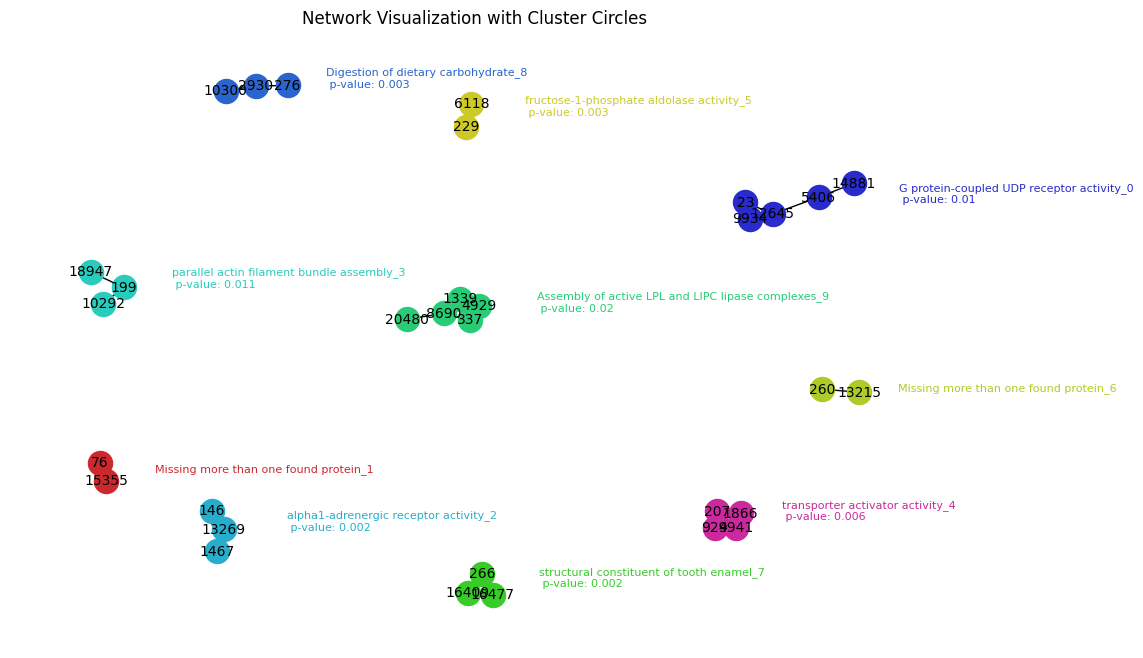

In [30]:
G = nx.Graph()

# Assign a color for each cluster
cluster_colors = {}
p_values = []
for i, cluster in enumerate(cluster_data):
    labels, edges = cluster
    if len(labels[0]) > 1:
        label = labels[0]
        p_values.append(labels[1])
    else:
        label = labels
        p_values.append(1)
    label = f"{label}_{i}"  # Add unique suffix
    color = hsv_to_rgb((random.random(), 0.8, 0.8))  # Random bright color
    cluster_colors[label] = color
    
    # Add nodes and edges to the graph
    for node, connections in edges.items():
        G.add_node(node, cluster=label)  # Add node with cluster label
        for neighbor, weight in connections.items():
            G.add_edge(node, neighbor, weight=weight)

# Draw the graph
plt.figure(figsize=(12, 8))

# Get node positions using a layout algorithm
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

counter = 0
# Draw nodes with colors based on cluster
for cluster, color in cluster_colors.items():
    nodes_in_cluster = [n for n, attr in G.nodes(data=True) if attr['cluster'] == cluster]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster, node_color=[color], label=cluster)

    # Calculate the bounding circle for the cluster
    x_coords = [pos[node][0] for node in nodes_in_cluster]
    y_coords = [pos[node][1] for node in nodes_in_cluster]
    center_x = sum(x_coords) / len(x_coords)
    center_y = sum(y_coords) / len(y_coords)
    radius = max(
        ((x - center_x)**2 + (y - center_y)**2)**0.5 
        for x, y in zip(x_coords, y_coords)
    ) + 0.1  # Add a margin
    
    # Draw the circle
    #circle = plt.Circle((center_x, center_y), radius, color=color, fill=False, linewidth=2, alpha=0.5)
    #plt.gca().add_artist(circle)

    # Add the label near the circle
    if p_values[counter] != 1:
        plt.text(center_x + radius, center_y, f"{cluster}\n p-value: {round(p_values[counter], 3)}", fontsize=8, color=color)
    else:
        plt.text(center_x + radius, center_y, f"{cluster}", fontsize=8, color=color)
    counter += 1

# Visualize the network
plt.title("Network Visualization with Cluster Circles")
plt.axis("off")
plt.show()

## Graphing

In [14]:
### Test data from netwulf ###
with open("./miserables.json", "r") as jsonfile:
    allstring = ""
    for line in jsonfile:
        allstring += line.rstrip()
data = json.loads(allstring)
print(data)
nx.visualize(data)

{'nodes': [{'id': 'Myriel', 'size': 1}, {'id': 'Napoleon', 'size': 1}, {'id': 'Mlle.Baptistine', 'size': 1}, {'id': 'Mme.Magloire', 'size': 1}, {'id': 'CountessdeLo', 'size': 1}, {'id': 'Geborand', 'size': 1}, {'id': 'Champtercier', 'size': 1}, {'id': 'Cravatte', 'size': 1}, {'id': 'Count', 'size': 1}, {'id': 'OldMan', 'size': 1}, {'id': 'Labarre', 'size': 2}, {'id': 'Valjean', 'size': 2}, {'id': 'Marguerite', 'size': 3}, {'id': 'Mme.deR', 'size': 2}, {'id': 'Isabeau', 'size': 2}, {'id': 'Gervais', 'size': 2}, {'id': 'Tholomyes', 'size': 3}, {'id': 'Listolier', 'size': 3}, {'id': 'Fameuil', 'size': 3}, {'id': 'Blacheville', 'size': 3}, {'id': 'Favourite', 'size': 3}, {'id': 'Dahlia', 'size': 3}, {'id': 'Zephine', 'size': 3}, {'id': 'Fantine', 'size': 3}, {'id': 'Mme.Thenardier', 'size': 4}, {'id': 'Thenardier', 'size': 4}, {'id': 'Cosette', 'size': 5}, {'id': 'Javert', 'size': 4}, {'id': 'Fauchelevent', 'size': 0}, {'id': 'Bamatabois', 'size': 2}, {'id': 'Perpetue', 'size': 3}, {'id': 

AttributeError: module 'networkx' has no attribute 'visualize'

In [28]:
### Our data format ###
# clusters = [ [Enrichment label, {"prot1": {"prot2" : edge_score} } ] , [Enrichment label, {"prot1": {"prot2" : edge_score} } ] ...]
test_data = [["enrich_label1", {"prot1": {"prot2" : 2}}], ["enrich_label2", {"prot2": {"prot3" : 2}}], ["enrich_label3", {"prot3": {"prot1" : 2}}], ["enrich_labe14", {"prot4": {"prot2" : 2}}]]

network = f.construct_graph(cluster_data, debug_mode=True)
print(network)
wulf.visualize(network)

##### Splitting label and cluster dict #####
[['G protein-coupled UDP receptor activity', 0.010289388815658551], {23: {12645: 1, 9934: 1}, 12645: {23: 1, 5406: 1, 9934: 1}, 9934: {23: 1, 12645: 1}, 5406: {14881: 1, 12645: 1}, 14881: {5406: 1}}]
[['amyloid-beta complex', 0.005249581391134628], {103: {14908: 1}, 14908: {103: 1, 2443: 1, 6093: 1, 18344: 1, 19186: 1, 16512: 1}, 2443: {14908: 1}, 6093: {14908: 1}, 18344: {14908: 1}, 19186: {14908: 1}, 16512: {14908: 1}}]
[['1-alkyl-2-acetylglycerophosphocholine esterase activity', 0.02412735338412422], {236: {10514: 1, 5666: 1, 14554: 1, 3568: 1, 16327: 1, 14860: 1, 18647: 1, 749: 1, 5051: 1, 15027: 1, 2831: 1}, 10514: {236: 1, 749: 1, 2831: 1, 5051: 1, 5666: 1, 18647: 1, 14860: 1, 16327: 1, 14554: 1, 15027: 1, 14217: 1}, 5666: {236: 1, 16327: 1, 10514: 1}, 14554: {236: 1, 749: 1, 2831: 1, 5051: 1, 10514: 1, 14217: 1, 18647: 1, 14860: 1, 16327: 1, 15027: 1}, 3568: {236: 1, 5051: 1}, 16327: {236: 1, 5051: 1, 5666: 1, 10514: 1, 14217: 1, 1455

FileExistsError: [Errno 17] File exists: '/Users/s243564/.netwulf'

In [17]:
for cluster in cluster_data:
    print(cluster)

['G protein-coupled UDP receptor activity', {23: {12645: 1, 9934: 1}, 12645: {23: 1, 5406: 1, 9934: 1}, 9934: {23: 1, 12645: 1}, 5406: {14881: 1, 12645: 1}, 14881: {5406: 1}}]
['Assembly of active LPL and LIPC lipase complexes', {337: {4929: 1, 8690: 1, 1339: 1}, 4929: {337: 1, 1339: 1, 8690: 1}, 8690: {337: 1, 1339: 1, 4929: 1, 20480: 1}, 1339: {337: 1, 8690: 1, 4929: 1}, 20480: {8690: 1}}]
['adenine binding', {353: {4076: 1}, 4076: {353: 1, 4845: 1}, 4845: {1249: 1, 4076: 1}, 1249: {8516: 1, 4845: 1}, 8516: {1249: 1}}]
['Gap junction assembly', {460: {2703: 1, 17577: 1}, 2703: {460: 1, 17577: 1, 9541: 1}, 17577: {460: 1, 2703: 1, 9541: 1, 12533: 1}, 9541: {2703: 1, 17577: 1, 12533: 1}, 12533: {9541: 1, 17577: 1}}]
['Response to metal ions', {569: {13792: 1, 17705: 1, 4490: 1, 6832: 1}, 13792: {569: 1, 4490: 1, 6832: 1, 8373: 1, 12354: 1, 17705: 1}, 17705: {569: 1, 4490: 1, 6832: 1, 8373: 1, 12354: 1, 13792: 1}, 4490: {569: 1, 13792: 1, 17705: 1, 6832: 1, 8373: 1, 12354: 1}, 6832: {56